In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
from plotly.offline import iplot
import plotly.graph_objs as go

sales = pd.read_csv('Sales_simulation.csv')
print('Data shape:')
print(sales.shape)
print('')
print('Informacion Data:')
print(sales.info())

Data shape:
(23230, 8)

Informacion Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23230 entries, 0 to 23229
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       23230 non-null  int64 
 1   purchase_ID      23230 non-null  int64 
 2   Date at created  23230 non-null  object
 3   Category         23230 non-null  object
 4   Name             23230 non-null  object
 5   Purchase Price   23230 non-null  int64 
 6   Delivery Price   23230 non-null  int64 
 7   Total            23230 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.4+ MB
None


### Informacion

- Purchase_ID : numero compra
- Date at created: fecha creacion de la orden
- Category: categoria del restaurante
- Name : nombre del restaurant 
- Purchase Price: la cantidad de dinero que se pagó por la compra COP
- Delivery Price: la cantidad de dinero que se paga por el envio COP
- Total : Purchase Price + Delivery Price COP


In [2]:
for column in sales.columns:
    print(column,sales[column].nunique())

Unnamed: 0 23230
purchase_ID 23230
Date at created 23230
Category 74
Name 240
Purchase Price 28
Delivery Price 39
Total 598


La columna 'Unnamed' es el numero de fila en la data, como no es importante la eliminaremos.

In [3]:
sales = sales[['purchase_ID', 'Date at created', 'Category', 'Name',
       'Purchase Price', 'Delivery Price', 'Total']]
sales.head()

purchase_ID             Date at created                  Category  \
0            1  21-10-2020 14:42:55.373979     Saludable · Desayunos   
1            2  21-10-2020 14:42:55.483563                   Postres   
2            3  21-10-2020 14:42:55.739536         Postres · Helados   
3            4  21-10-2020 14:42:55.945560  Hamburguesas · Saludable   
4            5  21-10-2020 14:42:56.201561       Postres · Desayunos   

                    Name  Purchase Price  Delivery Price  Total  
0       Distrito Gourmet           10700            3700  14400  
1      Toledo Pastelería           53900            6800  60700  
2                   Mahé            7500            6000  13500  
3         Restaurant Inn           23000            6100  29100  
4  Maria Luisa - Postres            9000            4300  13300

Vamos a separar la fecha en la columna hora, minuto y segundo ya que estas transacciones pasan en el mismo dia.

In [4]:
sales['Date at created'] =  pd.to_datetime(sales['Date at created'])
sales['Hour'] = sales['Date at created'].dt.hour
sales['Minute'] = sales['Date at created'].dt.minute 
sales['Second'] = sales['Date at created'].dt.second 
sales.head()

purchase_ID            Date at created                  Category  \
0            1 2020-10-21 14:42:55.373979     Saludable · Desayunos   
1            2 2020-10-21 14:42:55.483563                   Postres   
2            3 2020-10-21 14:42:55.739536         Postres · Helados   
3            4 2020-10-21 14:42:55.945560  Hamburguesas · Saludable   
4            5 2020-10-21 14:42:56.201561       Postres · Desayunos   

                    Name  Purchase Price  Delivery Price  Total  Hour  Minute  \
0       Distrito Gourmet           10700            3700  14400    14      42   
1      Toledo Pastelería           53900            6800  60700    14      42   
2                   Mahé            7500            6000  13500    14      42   
3         Restaurant Inn           23000            6100  29100    14      42   
4  Maria Luisa - Postres            9000            4300  13300    14      42   

   Second  
0      55  
1      55  
2      55  
3      55  
4      56

Borraremos la columna de fecha ya que no la usaremos.

In [5]:
sales = sales.drop('Date at created',axis=1)

In [6]:
sales.describe()

purchase_ID  Purchase Price  Delivery Price         Total  \
count  23230.000000    23230.000000    23230.000000  23230.000000   
mean   11615.500000    28588.240207     4901.450710  33489.690917   
std     6706.067713    16845.880909     1147.284454  16867.159241   
min        1.000000     7500.000000     3000.000000  10500.000000   
25%     5808.250000    13600.000000     3900.000000  18900.000000   
50%    11615.500000    24300.000000     4900.000000  29600.000000   
75%    17422.750000    37900.000000     5900.000000  42600.000000   
max    23230.000000    70000.000000     6800.000000  76800.000000   

               Hour        Minute        Second  
count  23230.000000  23230.000000  23230.000000  
mean      15.033836     29.140034     29.453207  
std        0.636317     18.679429     17.308418  
min       14.000000      0.000000      0.000000  
25%       15.000000     12.000000     14.000000  
50%       15.000000     27.000000     29.000000  
75%       15.000000     47.000000     44.000000  
max       16.000000     59.000000     59.000000

Podemos ver que el precio promedio es de $28588$ con un precio minimo de $7500$ y un precio maximo de $70000.$ Por otro lado, en cuanto al envio tenemos un precio promedio es de $4901$ con un precio minimo de $3000$ y un precio maximo de $6800.$

In [7]:
import plotly.express as px
df = sales[['Purchase Price','Delivery Price','Total']]

fig = px.box(df.melt(), y="value", facet_col="variable",facet_col_wrap=2, boxmode="overlay", color="variable",height=1000, width=900)
fig.update_yaxes(matches=None)

for i in range(len(fig["data"])):
    yaxis_name = 'yaxis' if i == 0 else f'yaxis{i + 1}'
    fig.layout[yaxis_name].showticklabels = True

fig.update_layout(showlegend=False)
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey')

fig.show()

Podemos ver que no hay valores atipicos, ademas que los costos de envio y costo son bastante cercanos.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



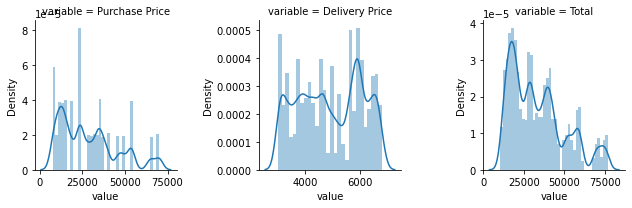

In [8]:
nd = pd.melt(df, value_vars =df )
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

Nuestras variables son multinormales.

In [9]:
sales.isna().sum()

purchase_ID       0
Category          0
Name              0
Purchase Price    0
Delivery Price    0
Total             0
Hour              0
Minute            0
Second            0
dtype: int64

<Figure size 1440x4320 with 0 Axes>

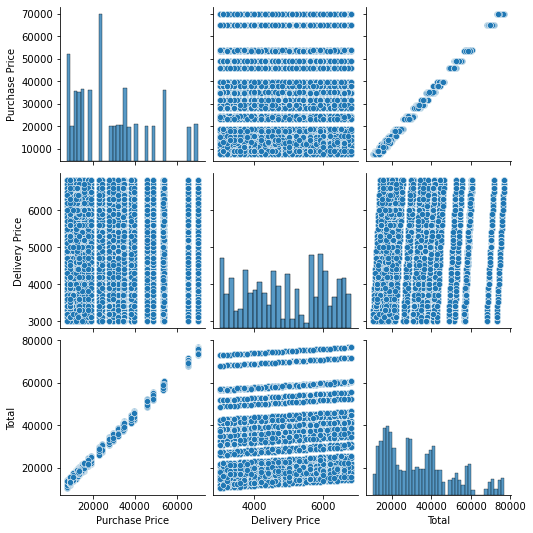

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,60))
sns.pairplot(df)
plt.show()

In [13]:
df_category = sales.groupby('Category')['Total'].agg([len, min, max])
df_category.sort_values('len')

len    min    max
Category                                              
Sushi · Desayunos                     77  11800  74300
Alta Cocina · Italiana                81  13500  76000
Hamburguesas · Panadería              81  13700  76200
Perros Calientes                      81  12400  74900
Hamburguesas · Pescados y Mariscos    86  14000  76500
...                                  ...    ...    ...
Desayunos                           1337  10600  76800
Saludable · Desayunos               1538  10500  76700
Desayunos · Típica                  1586  10800  76600
Típica                              1719  10500  76600
Postres · Desayunos                 1770  10800  76600

[74 rows x 3 columns]

Podemos ver que Postres · Desayunos,   y Típica son las categorias mas pedidas, sin embargo no son las categorias con mayor total.

<AxesSubplot:xlabel='Hour'>

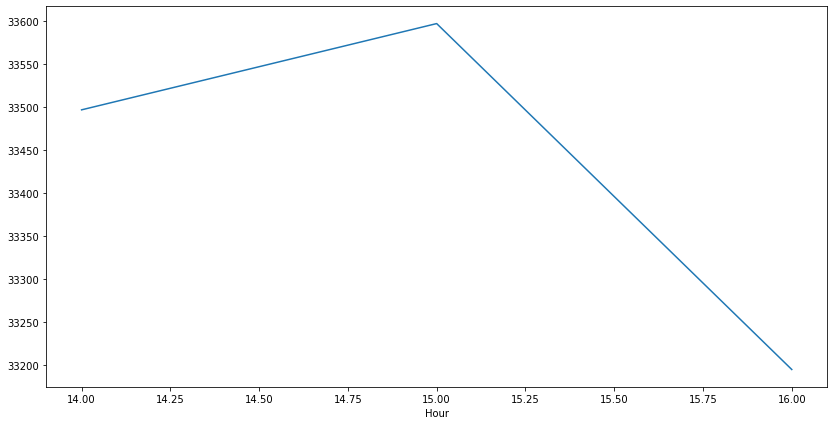

In [15]:
sales_hour = sales.groupby(['Hour'])['Total'].mean()
plt.figure(figsize=(14,7))
sales_hour.plot()

Podemos ver que antes de las $15h$ rappi recibe mas dinero, en cambio despues de esa hora este valor disminuye considerablemente.

<AxesSubplot:xlabel='Minute'>

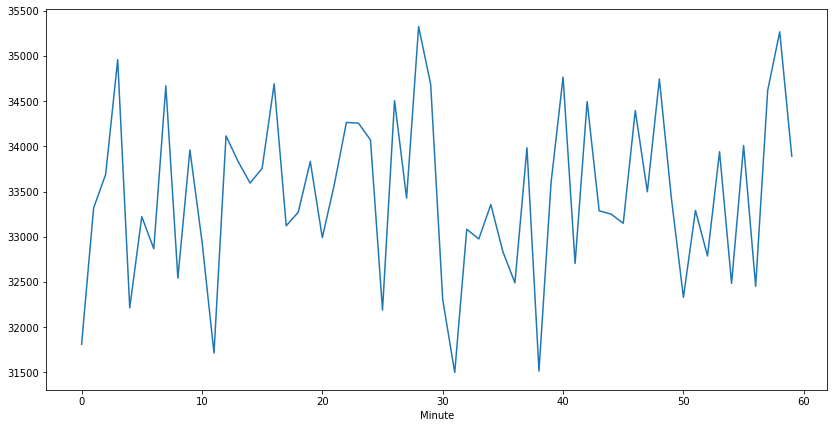

In [16]:
sales_min = sales.groupby(['Minute'])['Total'].mean()
plt.figure(figsize=(14,7))
sales_min.plot()

Podemos ver que en cuestion de minutos si varia mas el fluo de dinero que entra, sin embargo tenemos un valor maximo que esta cercano a los $30min$

<AxesSubplot:xlabel='Second'>

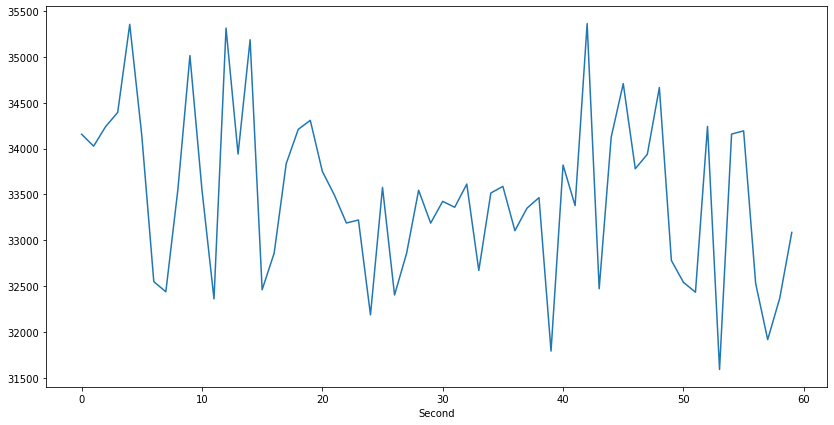

In [17]:
sales_sec = sales.groupby(['Second'])['Total'].mean()
plt.figure(figsize=(14,7))
sales_sec.plot()

Igual que en los minutos, podemos ver que varia el fluo de dinero que entra, sin embargo tenemos tres valor maximo que esta cercano a los $10seg$ y $40seg$.

In [19]:
second_sales = sales['Second'].values

split = int(len(second_sales)/2)
print(split)

11615


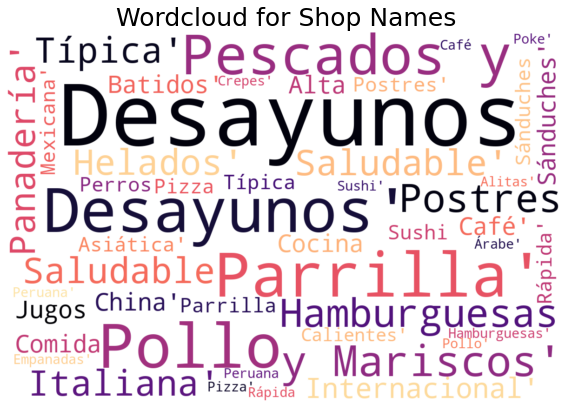

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


plt.rcParams['figure.figsize'] = (10, 10)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white',
                      colormap='magma',
                      max_words = 10000, 
                      stopwords = stopwords ,
                      width = 1200,
                      height = 800,
                     random_state = 20).generate(str(sales['Category'].unique()))


plt.title('Wordcloud for Shop Names', fontsize = 25)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

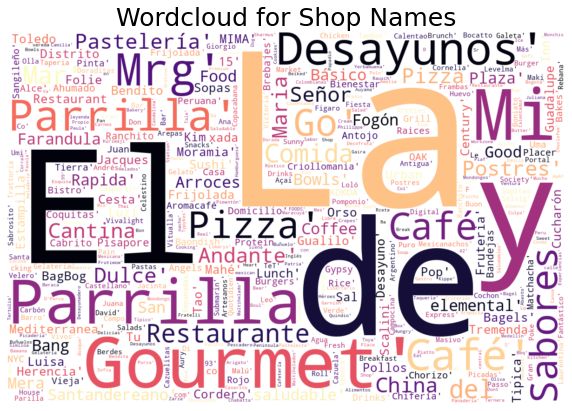

In [22]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


plt.rcParams['figure.figsize'] = (10, 10)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white',
                      colormap='magma',
                      max_words = 10000, 
                      stopwords = stopwords ,
                      width = 1200,
                      height = 800,
                     random_state = 20).generate(str(sales['Name'].unique()))


plt.title('Wordcloud for Shop Names', fontsize = 25)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

## Modelo predictivo

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
def predictEvaluation(y_feature, predictions):
    mae = mean_absolute_error(y_feature, predictions)
    mse = mean_squared_error(y_feature, predictions)
    rmse = np.sqrt(mean_squared_error(y_feature, predictions))
    r_squared = r2_score(y_feature, predictions)
    mape = np.mean(np.abs((y_feature - predictions)/y_feature))*100
    
    return mae, mse, rmse, r_squared, mape


model_name = []
data = []
parameter = []
result = []

def model_compare(xmodel, xdata, xpara, xresult):
    model_name.append(xmodel)
    data.append(xdata)
    parameter.append(xpara)
    result.append(xresult)

In [25]:
from sklearn.preprocessing import LabelEncoder
sales['Category'] = LabelEncoder().fit_transform(sales['Category'].values.reshape(-1,1))
sales['Name'] = LabelEncoder().fit_transform(sales['Name'].values.reshape(-1,1))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [48]:
import statsmodels.api as sm
mod_ses = sm.tsa.statespace.ExponentialSmoothing(sales)
res_ses = mod_ses.fit()

# Holt's linear method, denoted (A,A,N)
mod_h = sm.tsa.statespace.ExponentialSmoothing(sales, trend=True)
res_h = mod_h.fit()

# Damped trend model, denoted (A,Ad,N)
mod_dt = sm.tsa.statespace.ExponentialSmoothing(sales, trend=True,
                                                damped_trend=True)
res_dt = mod_dt.fit()

# Holt-Winters' trend and seasonality method, denoted (A,A,A)
# (assuming that `endog` has a seasonal periodicity of 4, for example if it
# is quarterly data).
mod_hw = sm.tsa.statespace.ExponentialSmoothing(sales, trend=True,
                                                seasonal=4)
res_hw = mod_hw.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72121D+00    |proj g|=  8.98889D-01


 This problem is unconstrained.



At iterate    5    f=  1.42052D+00    |proj g|=  1.50074D-03

At iterate   10    f=  1.41906D+00    |proj g|=  4.61876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     15      1     0     0   5.789D-06   1.419D+00
  F =   1.4190227543017246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.77598D+00    |proj g|=  9.99995D-01

At iterate    5    f= -4.54189D+00    |proj g|=  3.13215D+01

At iterate   10    f= -8.24985D+00    |proj g|=  6.92921D+02

At iterate   15    f= -1.02045D+01    |proj g|=  9.25714D+03

At iterate   20    f= -1.33351D+01    |proj g|=  9.13944D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     97      2     0     0   9.139D+04  -1.334D+01
  F =  -13.335059102814236     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98766D+00    |proj g|=  8.92479D-01

At iterate    5    f= -2.45834D+00    |proj g|=  2.42950D-02

At iterate   10    f= -2.49145D+00    |proj g|=  2.38460D-03

At iterate   15    f= -2.49295D+00    |proj g|=  1.82714D-03

At iterate   20    f= -2.49303D+00    |proj g|=  1.09824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     26      1     0     0   7.375D-06  -2.493D+00
  F =  -2.4930273934187923     

CONVERG

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.58677D-01    |proj g|=  5.34718D-01

At iterate    5    f= -2.59400D+00    |proj g|=  4.97664D-01

At iterate   10    f= -4.50808D+00    |proj g|=  1.11182D+01

At iterate   15    f= -6.52593D+00    |proj g|=  3.29338D+01

At iterate   20    f= -8.57841D+00    |proj g|=  2.94387D+02

At iterate   25    f= -9.81215D+00    |proj g|=  9.58361D+02

At iterate   30    f= -1.06942D+01    |proj g|=  2.56529D+03

At iterate   35    f= -1.20100D+01    |proj g|=  1.05825D+04

At iterate   40    f= -1.32164D+01    |proj g|=  2.70301D+04

At iterate   45    f= -1.37539D+01    |proj g|=  5.89928D+04

At iterate   50    f= -1.41334D+01    |proj g|=  9.24890D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [49]:
print(res_hw.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:3108: RuntimeWarning:

invalid value encountered in double_scalars

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning:

invalid value encountered in true_divide



                                                                     Exponential Smoothing Results                                                                      
Dep. Variable:     ['purchase_ID', 'Category', 'Name', 'Purchase Price', 'Delivery Price', 'Total', 'Hour', 'Minute', 'Second']   No. Observations:                23230
Model:                                                                                                             ETS(A, A, A)   Log Likelihood             3218558.862
Date:                                                                                                          Wed, 16 Mar 2022   AIC                       -6437099.724
Time:                                                                                                                  15:45:12   BIC                       -6437027.245
Sample:                                                                                                                       0   HQIC                     